# Higher-Order Regression

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [155]:
class HigherOrderRegressor():
    def __init__(self, degree):
        self.degree = degree
        self.X = None
        self.Y = None
        self.B = None
        self.num_features = None
        self.vander = []

    def fit(self, X, Y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        self.num_features=X.shape[1]
        indices=np.random.shuffle(np.arange(X.shape[0]))
        temp_X = X[indices][0]
        temp_Y = Y[indices][0]
        # np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.orig_X = np.hstack((np.ones((X.shape[0], 1)), temp_X))
        self.Y = temp_Y
        self.X = self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0])).T
        print(np.vander(self.orig_X[:,1], self.degree+1, increasing=True))
        self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                            np.matmul(self.X.T, self.Y))

    def generate_powers(self, x):
        powers = [1]
        for i in range(1, self.degree+1):
            powers.append(powers[-1]*x)
        return np.array(powers)

    def recursive_generate_powers(self, max_feature_encountered, current_degree, current_product, use_orig=True):
        if current_degree == 0:
            return current_product
        result=[]
        for i in range(max_feature_encountered, self.num_features+1):
            if use_orig:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.orig_X[:,i]))
            else:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.test_X[:,i], False))
        result=np.vstack(result)
        return result
    
    def predict_one(self, x):
        return np.dot(self.generate_powers(x), self.B)

    def predict(self, X):
        self.test_X=np.hstack((np.ones((X.shape[0], 1)), X))
        self.final_testX=self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0]), False).T
        return np.matmul(self.final_testX, self.B)

    def sum_of_squares(self, Y_true, Y_pred):
        return np.sum((Y_true - Y_pred)**2)
        
    def r2_score(self, Y_true, Y_pred):
        # return np.sum((Y_true - Y_pred)**2)
        return 1 - np.sum((Y_true - Y_pred)**2) / np.sum((Y_true - np.mean(Y_true))**2)

    def k_fold_testing(self, k=10):
        width = self.X.shape[0]//k
        average_r2 = 0
        count = 0
        for i in range(0, self.X.shape[0], k):
            count += 1
            X_train = np.concatenate((self.X[:i], self.X[i+width:]))
            Y_train = np.concatenate((self.Y[:i], self.Y[i+width:]))
            X_test = self.X[i:i+width]
            Y_test = self.Y[i:i+width]
            B = np.matmul(np.linalg.inv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            predictions = np.matmul(X_test, B)
            # average_r2 += r2_score(Y_test, predictions)
            average_r2 += self.r2_score(Y_test, predictions)
        B = np.matmul(np.linalg.inv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        return average_r2/count, np.matmul(self.X, B)
    
    def cross_validation(self, params):
        maximum_param=np.max(params)
        self.max_X=np.vander(self.orig_X, maximum_param+1, increasing=True)
        responses = []
        for param in params:
            self.degree = param
            self.X=self.max_X[:,:param+1]
            response, plot_values = self.k_fold_testing()
            responses.append(response)
            # fig=plt.figure()
            # plt.scatter(self.orig_X, self.Y)
            # indices=np.argsort(self.orig_X)
            # plt.plot(self.orig_X[indices], plot_values[indices], 'red')
            # fig.savefig(f"degree_{param}.png")
        print(responses)
    
    def write_params(self):
        with open("3_weights.pkl", "wb") as f:
            pickle.dump(self.B, f)


In [5]:
train_data=pd.read_csv('train.csv')

In [6]:
X=train_data['x'].to_numpy()
Y=train_data['y'].to_numpy()

In [162]:
regressor=HigherOrderRegressor(3)

In [163]:
regressor.fit(X,Y)

In [113]:
test_data=pd.read_csv('test.csv')

In [114]:
X_test=test_data['x'].to_numpy()

In [119]:
regressor2=HigherOrderRegressor(3)

In [46]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [74]:
regressor.fit(X_train,Y_train)

In [75]:
data=regressor.predict(X_val)

In [76]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [77]:
r2_score(Y_val, data)

0.8776829081113265

In [78]:
mean_squared_error(Y_val, data)

819.8538414941444

In [79]:
mean_absolute_error(Y_val, data)

22.557238245353524

In [102]:
regressor.cross_validation([2,3,4,5,6,7,8,9,10])

[0.7405248627800795, 0.8110940468157531, 0.885533449535035, 0.8890032715554141, 0.8890277101115677, 0.888332487004736, 0.887539875919861, 0.8879689135086817, 0.8869996684551753]


In [164]:
regressor.cross_validation([2,3,4,5,6,7,8,9,10])

[56427.175480097954, 39251.2107718163, 24080.14499184062, 23135.01264391381, 23147.39205431092, 23316.53520429746, 23507.28378862272, 23391.932968519566, 23591.837720512074]


In [168]:
regressor3=HigherOrderRegressor(5)

In [169]:
regressor3.fit(X,Y)

In [170]:
regressor3.write_params()

In [171]:
test_data=pd.read_csv('test.csv')
X_test=test_data['x'].to_numpy()
test_data['y']=regressor3.predict(X_test)

In [172]:
test_data.to_csv('3_predictions.csv', index=False)

In [191]:
regressor4=HigherOrderRegressor(20)
regressor4.fit(X, Y)
regressor4.cross_validation(np.arange(1, 25))

[0.7073677200099657, 0.7405248627800795, 0.8110940468157531, 0.885533449535035, 0.8890032715554141, 0.8890277101115677, 0.888332487004736, 0.887539875919861, 0.8879689135086817, 0.8869996684551753, 0.8860458564815987, 0.8838815115222338, 0.882803391131459, 0.8827889386885583, 0.8805258162942892, 0.8837670082600091, 0.8842901613457899, 0.8871751805158606, 0.8819040050828425, 0.8816272586091627, 0.8799340747233307, 0.8634185203165906, -17.509161117014038, -62.03234099389781]


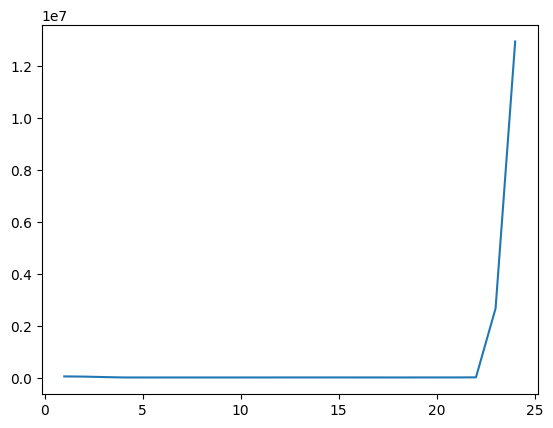

In [189]:
plt.plot(np.arange(1, 25), [64653.555302618384, 56427.175480097954, 39251.2107718163, 24080.14499184062, 23135.01264391381, 23147.39205431092, 23316.53520429746, 23507.28378862272, 23391.932968519566, 23591.837720512074, 23799.29808194501, 24306.126217608657, 24567.738597261134, 24511.039529749152, 25040.059015164665, 24245.658838890413, 24135.381150518013, 23388.984818572288, 24449.065706832644, 24631.227983779838, 24937.833575556066, 28290.30555397866, 2673741.993952508, 12928066.182318613])

In [192]:
X_new=train_data.to_numpy()

In [156]:
regressor=HigherOrderRegressor(5)
X = X.reshape(-1, 1)  # Reshape X to have a single column if it's 1D
Y = Y.reshape(-1, 1)

In [157]:
regressor.fit(X, Y)

[[ 1.00000000e+00  4.33511435e-01  1.87932164e-01  8.14707421e-02
   3.53184983e-02  1.53109729e-02]
 [ 1.00000000e+00 -1.44346461e+00  2.08359009e+00 -3.00758857e+00
   4.34134767e+00 -6.26658174e+00]
 [ 1.00000000e+00 -1.88092790e-01  3.53788977e-02 -6.65451558e-03
   1.25166640e-03 -2.35429426e-04]
 ...
 [ 1.00000000e+00  4.87637236e-01  2.37790074e-01  1.15955294e-01
   5.65441192e-02  2.75730180e-02]
 [ 1.00000000e+00 -2.22644221e+00  4.95704493e+00 -1.10365741e+01
   2.45722945e+01 -5.47087937e+01]
 [ 1.00000000e+00 -1.80002085e+00  3.24007506e+00 -5.83220267e+00
   1.04980864e+01 -1.88967744e+01]]


In [158]:
res=regressor.predict(X)

In [159]:
print(regressor.final_testX)

[[ 1.00000000e+00  4.33511435e-01  1.87932164e-01  8.14707421e-02
   3.53184983e-02  1.53109729e-02]
 [ 1.00000000e+00 -1.44346461e+00  2.08359009e+00 -3.00758857e+00
   4.34134767e+00 -6.26658174e+00]
 [ 1.00000000e+00 -1.88092790e-01  3.53788977e-02 -6.65451558e-03
   1.25166640e-03 -2.35429426e-04]
 ...
 [ 1.00000000e+00  4.87637236e-01  2.37790074e-01  1.15955294e-01
   5.65441192e-02  2.75730180e-02]
 [ 1.00000000e+00 -2.22644221e+00  4.95704493e+00 -1.10365741e+01
   2.45722945e+01 -5.47087937e+01]
 [ 1.00000000e+00 -1.80002085e+00  3.24007506e+00 -5.83220267e+00
   1.04980864e+01 -1.88967744e+01]]


In [160]:
r2_score(Y, res)

0.9057888113973666

In [132]:
from sklearn.metrics import r2_score

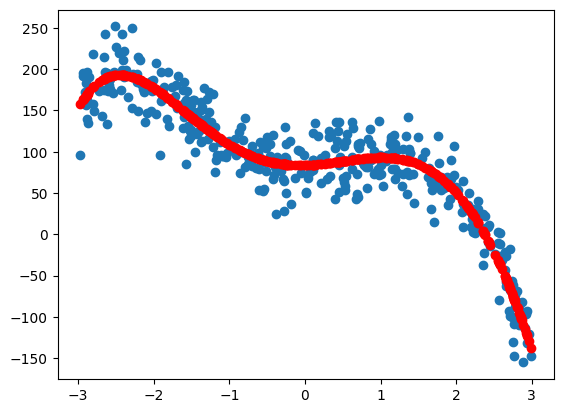

In [161]:
plt.scatter(X, Y)
plt.scatter(X, res, color='red')